# 0-Council-preprocessing 
## Notebook Purpose
 > This notebook correspond to the following tasks
* A). Data import & inspection
* B). Data cleansing , remapping &imputation  


# Install/update packages on colab env 
(Since some library versions might be obsolete on colab kernel)

In [1]:
!pip install --upgrade plotly -q
!pip install --upgrade pandas -q
!pip install --upgrade missingno -q

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Import libraries

In [3]:
import numpy as np
from scipy import stats

import pandas as pd
pd.options.plotting.backend = "plotly"
pd.options.display.max_rows=70
pd.options.display.max_columns=20
pd.options.display.notebook_repr_html= True

import missingno as msno
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os


# Load dataset
* Dataset spreads over many files of type xls on the council website.
* Since url is hashed an automated download will require selenium or another porwerful webscrapping module.
* I download the files manually and put them on gdrive for fast access with colab.
* Then they are fused in a single Dataframe (note concat is preferable to append)

In [4]:
colab_path= '/content/gdrive/MyDrive/ml-council/data-raw'

files_list=[]
# return all files as a list
for file in os.listdir(colab_path):
     # check the files which are end with specific extention
    if file.endswith(".xls"):
        #print(os.path.join(colab_path, file))
        files_list.append(os.path.join(colab_path, file))

In [ ]:
df= pd.DataFrame()
frames = [pd.read_excel(file) for file in files_list]
df = pd.concat(frames)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180269 entries, 0 to 2689
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   TRANS DATE          180268 non-null  datetime64[ns]
 1   TRANS VAT DESC      171054 non-null  object        
 2   ORIGINAL GROSS AMT  180268 non-null  float64       
 3   ORIGINAL CUR        48589 non-null   object        
 4   BILLING GROSS AMT   48589 non-null   float64       
 5   BILLING CUR CODE    83056 non-null   object        
 6   MERCHANT NAME       180268 non-null  object        
 7   CARD NUMBER         180268 non-null  object        
 8   TRANS CAC CODE 1    180168 non-null  object        
 9   TRANS CAC DESC 1    180168 non-null  object        
 10  TRANS CAC CODE 2    180041 non-null  object        
 11  TRANS CAC DESC 2    180041 non-null  object        
 12  TRANS CAC CODE 3    179985 non-null  object        
 13  Directorate         163671 non-

In [ ]:
first_run= False
if first_run:
  df.to_pickle('data-raw.pkl')
  df.to_pickle(colab_path+'/data-raw.pkl')
else:
  df=pd.read_pickle(colab_path+'/data-raw.pkl')


## Observation dataset values

In [ ]:
df.sample(20)

,TRANS DATE,TRANS VAT DESC,ORIGINAL GROSS AMT,ORIGINAL CUR,BILLING GROSS AMT,BILLING CUR CODE,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate,Directorates,TRANS TAX AMT,BILLING CUR CODE.1,Directorate,Unnamed: 10
159,2016-08-22,NaN,618.15,NaN,NaN,NaN,travelodge website,************1709,N060,Other Third Parties,RJADC,Homeless Private Sector Accom,A00,Adult & Communities,NaN,NaN,NaN,NaN,NaN
616,2015-10-22,VR,190.00,NaN,NaN,NaN,monster skips ltd,************4212,L120,Equip Other,REANR,Stechford Junior & Infant,A00,CYP&F,NaN,NaN,NaN,NaN,NaN
2681,2016-07-08,VZ,20.00,NaN,NaN,NaN,wilko the fort 424,************8429,L100,Equip Operational,REATL,International School & Community College,A00,CYP&F SCHOOLS,NaN,NaN,NaN,NaN,NaN
805,2016-01-27,VZ,16.11,NaN,NaN,NaN,amazon svcs europesar,************3406,L030,Books,REB17,EP CPD Capitation,A00,CYP&F,NaN,NaN,NaN,NaN,NaN
2264,2016-07-22,VZ,5.90,NaN,NaN,NaN,cash advance fee,************7482,MC70,Supplies & Sev Mic,REAER,Harborne JI,A00,CYP&F SCHOOLS,NaN,NaN,NaN,NaN,NaN
1705,2014-07-09,VZ,200.00,NaN,NaN,GBP,sain - wylde green,************9466,L540,Bank & Goro ChgsS,REAXZ,Hamilton,A00,CYP&F SCHOOLS,NaN,NaN,NaN,NaN,NaN
1000,2017-05-12,VZ,26.29,GBP,26.29,GBP,tesco-stores 6463,************4035,L220,Purchases Food,RV013,"Warwick Hse HLDC, 938 Warwick Rd B27",A00,CYP&F,NaN,NaN,NaN,NaN,NaN
2839,2017-07-20,VR,4.00,GBP,4.00,GBP,sportsdirect 79,************4136,L120,Equip Other,REANR,Stechford Junior & Infant,A00,CYP&F SCHOOLS,NaN,NaN,NaN,NaN,NaN
955,2017-05-23,VR,320.40,GBP,320.40,GBP,www.officefurnitureonl,************3483,L100,Equip Operational,RV0D3,YJ Intensive Supervision & Surveillance,A00,CYP&F,NaN,NaN,NaN,NaN,NaN
3016,2017-05-08,VZ,14.16,GBP,14.16,GBP,amazon uk marketplace,************4637,L100,Equip Operational,REALC,St Barnabas CE Junior & Infant (NC),A00,CYP&F SCHOOLS,NaN,NaN,NaN,NaN,NaN


In [ ]:
for column in df.columns[1::]:
    values = df[column].unique()
    print(f'{column} : #val: {len(values)} = {values}')
    #df['BILLING CUR CODE'].value_counts().plot(kind='bar')

TRANS VAT DESC : #val: 8 = ['VR' 'VZ' 'VL' nan 'VS' 'VE' 'VT' '6.65%']
ORIGINAL GROSS AMT : #val: 31738 = [ 45.    50.04  50.   ... 153.13 122.94 562.  ]
ORIGINAL CUR : #val: 19 = ['GBP' 'HUF' 'EUR' 'HRK' 'USD' 'CNY' 'PLN' 'CZK' 'PKR' 'RON' 'DKK' 'SEK'
 'CAD' 'SGD' 'MYR' 'NOK' 'HKD' 'QAR' nan]
BILLING GROSS AMT : #val: 17520 = [ 45.    50.04  50.   ... 158.09  90.84    nan]
BILLING CUR CODE : #val: 2 = ['GBP' nan]
MERCHANT NAME : #val: 15541 = ['malthurst petroleu' 'mibsons service st' 'beeches road servi' ...
 'kfc billingham' 'bay tree cafe' 'uk deed poll service']
CARD NUMBER : #val: 1500 = ['************5804' '************2823' '************7214' ...
 '************3522' '************8104' '************4784']
TRANS CAC CODE 1 : #val: 144 = ['K020' 'MC70' 'L120' 'L100' 'L6E0' 'X0A0' 'M900' 'K240' 'H0R0' 'H0T0'
 'K260' 'K300' 'H2T0' 'K080' 'L220' 'L000' 'K200' 'L420' 'L030' 'L080'
 'L680' 'L250' 'L670' 'K210' 'L5G0' 'L700' 'L110' 'J200' 'J210' 'J280'
 'L750' 'J030' 'L300' 'L9Y0' 'L0J0

# Summary of Inspection Findings
* Categorical with Large cardinality (>20):  
 - Merchants(15K) , 
 - cards ID (1500), 
 - Description/code2 (1370) 
 - Description/Code1 (150)
* Other hypothesis:
 - 'BILLING CUR CODE' might be one-class 
 - Transaction CAC and Description are probably self-replicating.
 - The 3 instances of Directorate columns and Unnamed have similar cardinality (18,15,11 ,11) and categories differ by at capitalization or typing. 




* verification of  TRANS CAC CODE 2  and TRANS CAC DESC 1  matching :

In [ ]:
col1 = 'TRANS CAC CODE 1' 
col2 = 'TRANS CAC DESC 1'
values1 = df[col1].unique()

flag= True

for val in values1:
  df_temp = df[col2].loc[df[col1] == val]
  if df_temp.nunique()> 1:
    flag= False
    print(f'{val} , {df_temp.unique()}')

if flag:
   print( 'Each CAC CODE 1 matches only 1 CAC DESC 1' ) 

Each CAC CODE 1 matches only 1 CAC DESC 1


* verification of  TRANS CAC CODE 2  and TRANS CAC DESC 2  mismatching cause and amount:

In [ ]:
col1 = 'TRANS CAC CODE 2' 
col2 = 'TRANS CAC DESC 2'
values1 = df[col1].unique()
for val in values1:
  df_temp = df[col2].loc[df[col1] == val]
  if df_temp.nunique()> 1:
    print(f'{val} , {df_temp.unique()}')

RETK5 , ['CLA 4 MFL and Culture - Central' 'Osborne Creche']
RTC40 , ['Local Engineering' 'Constituency Services']
RV0CL , ['Principal Social Worker ' 'Adoption Support']


In [ ]:
col1 = 'TRANS CAC CODE 2' 
col2 = 'TRANS CAC DESC 2'
values1 = df[col2].unique()
for val in values1:
  df_temp = df[col1].loc[df[col2] == val]
  if df_temp.nunique()> 1:
    print(f'{val} , {df_temp.unique()}')

Non-BCC LEP Core Fund , ['TA-02300-02' 'TA-02300-02 ']
Digital Birmingham , ['TA-01887-01 ' 'RDE03' 'TA-00555-01']
Integrated Services East , ['RV0KN' 'RV0KJ']
Beaufort , ['REAXM' 'RE1XM']
Stirchley Baths , ['rlt5h' 'RLT5H']
Business Support , ['RLXA1' 'RBH07' 'RTF40']
RHE03Ladywood Hsg Mgmt , ['rhe03' 'RHE03']
Director , ['RBL26' 'RVA0A' 'RV462']
Strategic Director Resources , ['rbb19' 'RBF00']
Council House , ['RBL01' 'RC801']
Acivico , ['A4A06' 'A5C01' 'A5B01' 'A4A03' 'A5A05']
Highbury , ['RC803' 'RC028']


* Reparation of Directorate:
 - Fixing of capitalization and spaces
 - Do not yet assume 'CYP&F SCHOOLS' == 'CYP&F'
  neither Adult & Communities == Adult Social Care and Health


In [ ]:
def fixing_string( s):
  try:
    return s.replace(" ", "").upper() # strip might be enough
  except Exception as e:
    return np.NAN

#print(fixing_string( 'car crash'))

col_list=['Directorate', 'Directorates', 'Directorate ', 'Unnamed: 10']


for col in col_list:
  df[col]=df[col].apply(fixing_string)  
  values = df[col].unique()
  mappings={col: {'CYO&F': 'CYP&F', 'ADULT&COMMUNITIES': 'ADULTS&COMMS', 
                  'ADULTS&COMMUNITIES':'ADULTS&COMMS', 'ADULTS':'ADULTS&COMMS',
                  'CORPORATEPROCUREMENT':'CORPORATERESOURCES',
                  ' ' : np.NaN}}
  df.replace(mappings,inplace=True)
  print(f'{col} : #val: {len(values)} = {values}')

Directorate : #val: 13 = ['ADULTSOCIALCAREANDHEALTH' 'CORPORATERESOURCES' 'CYP&F' 'CYP&FSCHOOLS'
 'DEVELOPMENT' 'LOCALSERVICES' nan 'ADULT&COMMUNITIES' 'ADULTS' 'CYO&F'
 'ADULTS&COMMUNITIES' 'ADULTS&COMMS' '']
Directorates : #val: 10 = [nan 'ADULTSOCIALCAREANDHEALTH' 'CORPORATERESOURCES' 'CYP&F'
 'CYP&FSCHOOLS' 'DEVELOPMENT' 'LOCALSERVICES' 'ADULT&COMMUNITIES' 'ADULTS'
 'CYO&F']
Directorate  : #val: 9 = [nan 'ADULT&COMMUNITIES' 'CORPORATEPROCUREMENT' 'CORPORATERESOURCES'
 'CYO&F' 'CYP&F' 'CYP&FSCHOOLS' 'DEVELOPMENT' 'LOCALSERVICES']
Unnamed: 10 : #val: 9 = [nan 'ADULT&COMMUNITIES' 'ADULTS&COMMS' 'CORPORATERESOURCES' 'CYO&F'
 'CYP&F' 'CYP&FSCHOOLS' 'DEVELOPMENT' 'LOCALSERVICES']


In [ ]:
high_cardinal=['TRANS DATE','MERCHANT NAME','CARD NUMBER','TRANS CAC CODE 2','TRANS CAC DESC 2' ]
numerical= ['TRANS DATE','ORIGINAL GROSS AMT','BILLING GROSS AMT','TRANS TAX AMT']
nominal= ['TRANS DATE','TRANS VAT DESC','ORIGINAL CUR','TRANS CAC CODE 1', 'TRANS CAC DESC 1','TRANS CAC CODE 3']
#Create a dataframe by dtypes 
df_numeric= df.loc[:,numerical]

In [ ]:
for col in df.columns[:]:
  if df[col].dtype=='object': 
    df[col] = df[col].astype('category')
df.info()

# Data cleansing
0. data look and  missing data quantifications
2. Remove unnecesary/poor information Information



In [ ]:
df_temp= df[col_list].sample(20)
df_temp

,Directorate,Directorates,Directorate,Unnamed: 10
499,CORPORATERESOURCES,NaN,NaN,NaN
2719,CYP&FSCHOOLS,NaN,NaN,NaN
762,CYP&F,NaN,NaN,NaN
4680,LOCALSERVICES,NaN,NaN,NaN
4055,LOCALSERVICES,NaN,NaN,NaN
3680,DEVELOPMENT,NaN,NaN,NaN
2813,CYP&FSCHOOLS,NaN,NaN,NaN
4043,NaN,CYP&FSCHOOLS,NaN,NaN
1282,CYP&FSCHOOLS,NaN,NaN,NaN
4977,LOCALSERVICES,NaN,NaN,NaN


* collapsing upon the first the directorate columns

In [ ]:
for i in [2,1,0]:
  df[col_list[i]] = df[col_list[i]].fillna(df[col_list[i+1]])
df.drop(col_list[1:],axis=1, inplace=True)

* Since the two columns CUrrency code, are 1 class and NAN and their missing quantity is sol high they  maybe non predictiva.

In [ ]:
df_temp = df.loc[:,['BILLING CUR CODE','BILLING CUR CODE.1']]
print(' missing rate ')
print(df_temp['BILLING CUR CODE.1'].isna().sum()*100/len(df_temp))
print(' missing rate ')
print(df_temp['BILLING CUR CODE'].isna().sum()*100/len(df_temp))
df.drop(['BILLING CUR CODE','BILLING CUR CODE.1'], axis=1, inplace=True)

 missing rate 
97.44936733437252
 missing rate 
53.92663186682125


## Missing data analysis

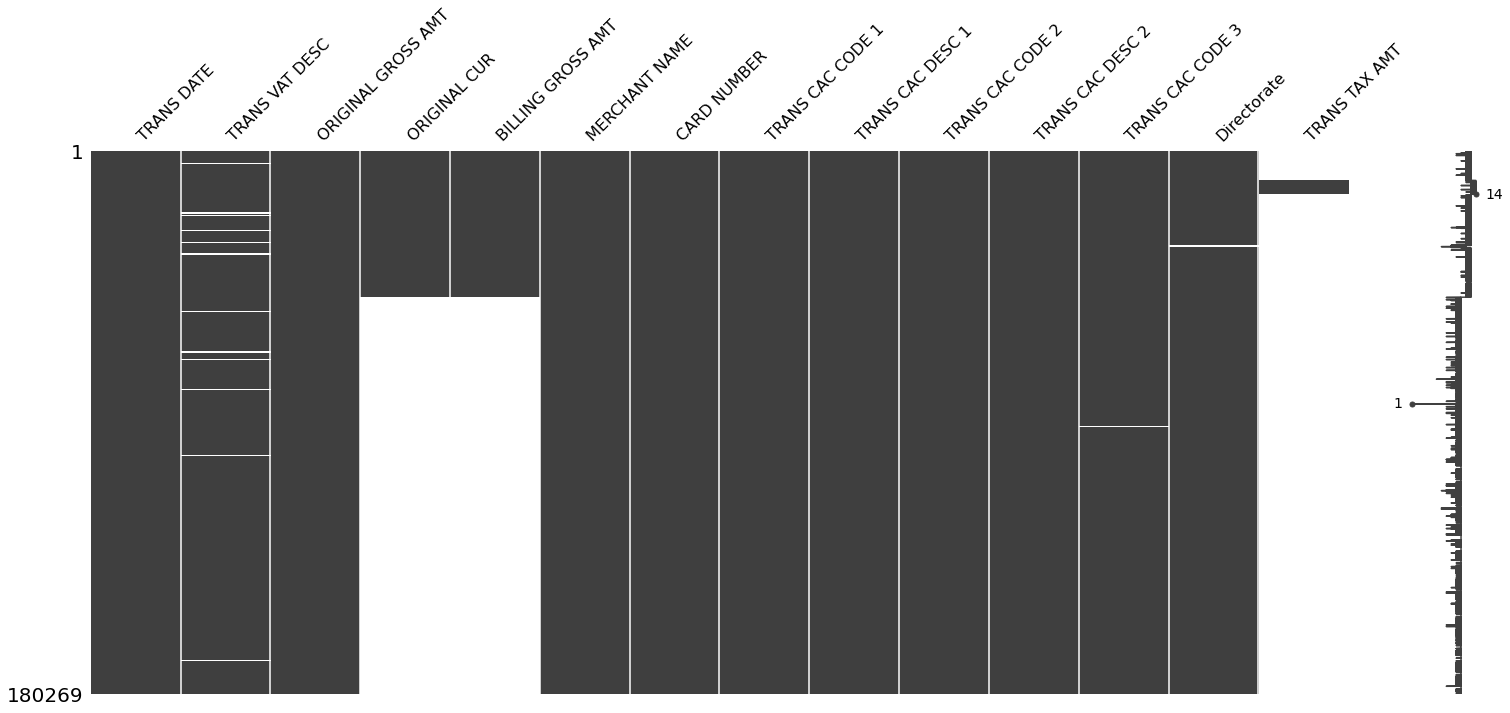

In [ ]:
# check sparcity  ( but table 1 of paper indicates it is low)
#plt.figure()
msno.matrix(df)

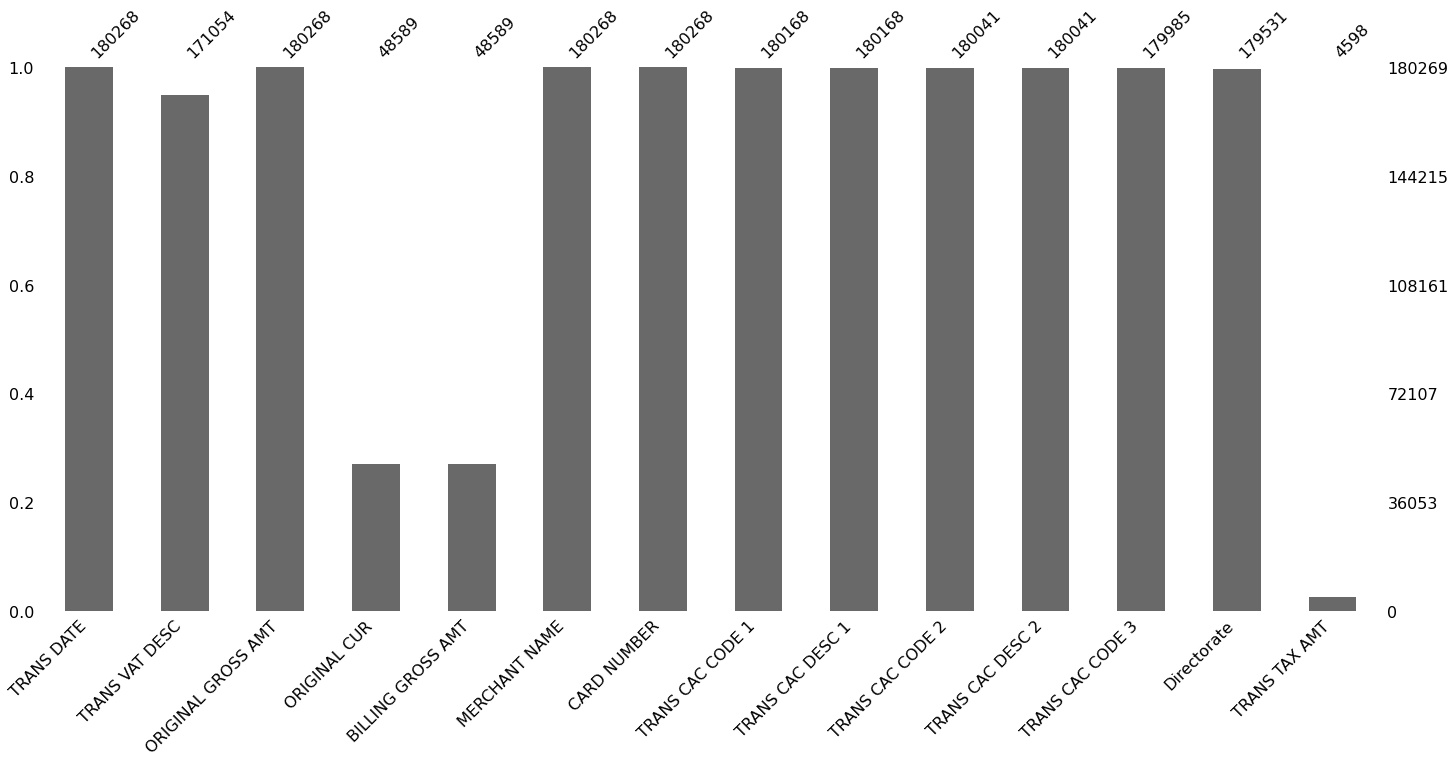

In [ ]:
pd.options.plotting.backend = "matplotlib"
msno.bar(df)

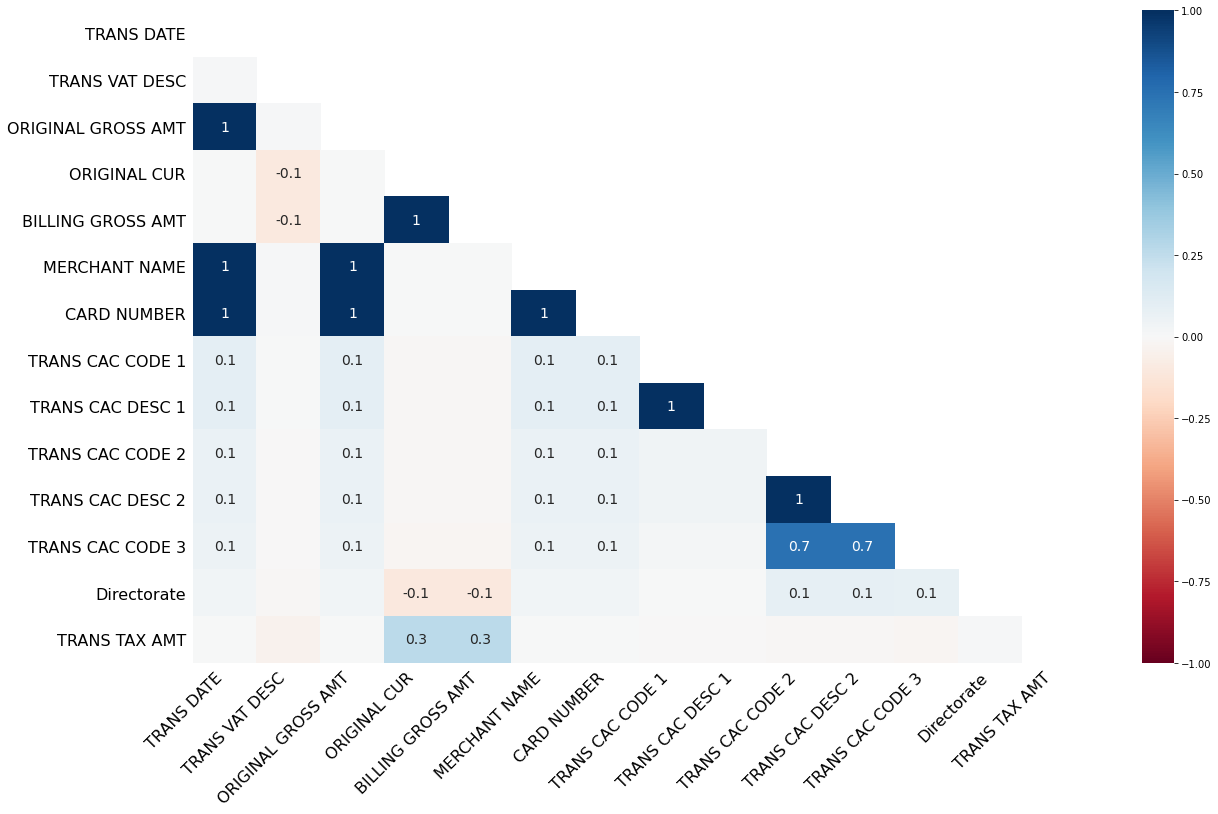

In [ ]:
#correlation among missing values
msno.heatmap(df)

* Observe if CODE is related to description to collapse by subject

In [ ]:
import string
df.dropna(axis=0, subset=[col1], inplace=True)

col1 = 'TRANS CAC CODE 1' 
col2 = 'TRANS CAC DESC 1'
values1 = df[col1].unique()
collapsed_codes=[]
for letter in string.ascii_uppercase:
  selected_values= [ val for val in values1 if val.startswith(letter)]
  if len(selected_values)!=0:
    collapsed_codes.append([selected_values,letter])
    print(selected_values)
    df_temp = df[col2].loc[df[col1].isin(selected_values)]
    print(f'{len(df_temp.unique())} , {df_temp.unique()}')

['H0R0', 'H0T0', 'H2T0', 'H2Q0', 'H240', 'H220', 'H400', 'H000', 'H030', 'H0M0']
10 , ['Conference Fees Subs UK' 'Conference Fees Subs Foreign' 'Training Other'
 'Training Travel&Subs' 'Training Tutor Fees' "Training EquipMat'ls"
 'Oth Indirect EmpExps' 'Staff Advert Exp' 'Employer Liab Ins'
 'Relocn&RecruitIncent']
['J200', 'J210', 'J280', 'J030', 'J020', 'J300', 'J040', 'J510', 'J500', 'J310', 'J010', 'J1A0', 'J560', 'J760', 'J1G0', 'J550', 'J250', 'J700', 'J0L0', 'J0D0', 'J220', 'J050', 'J100', 'J240', 'J0C0', 'J000', 'J3A0', 'J1F0', 'J400', 'J0Z0', 'J260', 'J0A0', 'J0V0', 'J1K5']
34 , ['Electricity' 'Gas' 'Water Services' 'Bldg RM Departmental'
 'Bldg RM Emergy UDD' "Fire/Sec'yAlarm/Eq't" 'Bldg RM Fair Fund NS'
 'Cleaning Contract' 'Cleaning Materials' 'Other Fix&Fittings'
 'Bldg RM Routine UDD' 'Grounds Maintenance' 'Refuse Collection'
 'Premises Misc' 'Liaison Bd Repairs' 'Disinfestation' 'Accomodation Hire'
 'Premises Provisions' 'HR&M Low Val Routine' 'HR&M NRC Contingency' 'Oi

* While expenditures by CAC 1 CODE seems to keep coherence it is hard to confirm it is a good choice yet since within class disparities, e.g Car parking and Vehicule tyres cost.  

In [ ]:
col1 = 'TRANS CAC CODE 1' 
col2 = 'TRANS CAC DESC 1'
values1 = df[col1].unique()

for values,letter in collapsed_codes:
  df[col1].replace(to_replace=values, value=letter ,inplace=True)

In [ ]:
df.tail()

,TRANS DATE,TRANS VAT DESC,ORIGINAL GROSS AMT,ORIGINAL CUR,BILLING GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate,TRANS TAX AMT
2685,2014-04-29,VR,34.36,NaN,NaN,doorfit products,************8673,L100,Equip Operational,RJHH8,Homeless Centre-Breedon Road,A00,LOCALSERVICES,NaN
2686,2014-04-28,VZ,7.44,NaN,NaN,post office counter,************8673,L420,Stationery,RJHH8,Homeless Centre-Breedon Road,A00,LOCALSERVICES,NaN
2687,2014-04-17,VR,27.00,NaN,NaN,dormy hotel,************8673,MC70,Supplies & Sev Mic,RJACG,H/Less Temporary Accomdtn Team,A00,LOCALSERVICES,NaN
2688,2014-04-10,VR,37.98,NaN,NaN,argos ltd,************8673,L100,Equip Operational,RJHH2,Homeless Centre-Northbrook,A00,LOCALSERVICES,NaN
2689,2014-04-08,VR,562.00,NaN,NaN,holiday inns,************8673,MC70,Supplies & Sev Mic,RJACG,H/Less Temporary Accomdtn Team,A00,LOCALSERVICES,NaN


* encoding time in day from first transaction

In [ ]:
from datetime import datetime, timedelta

time_zero= df.iloc[-1,0]  #datetime(2014,4,8)
time_one= df.iloc[-2,0]
d= time_one - time_zero
d.days
df['time_int']= df['TRANS DATE'].apply((lambda x: (x - time_zero).days)) 

In [ ]:
df['time_int'].hist() #datetime in days units

In [ ]:
first_run= False
if first_run:
  df.to_pickle('data-intermediate.pkl')
  df.to_pickle(colab_path+'/data-intermediate.pkl')
else:
  df=pd.read_pickle(colab_path+'/data-intermediate.pkl')

# Spurious values elimination
* Lets drop transactions with nan values, negative values and anomalous

In [ ]:
column='ORIGINAL GROSS AMT'
df.dropna(axis=0, subset=[column], inplace=True)
#print(df[column].isna().sum())
df[column].describe()

count    170678.000000
mean         71.257421
std          93.928147
min           0.010000
25%          13.000000
50%          39.000000
75%          81.940000
max         552.850000
Name: ORIGINAL GROSS AMT, dtype: float64

In [ ]:
df[column]= np.abs(df[column])
df[column].describe()

count    170678.000000
mean         71.257421
std          93.928147
min           0.010000
25%          13.000000
50%          39.000000
75%          81.940000
max         552.850000
Name: ORIGINAL GROSS AMT, dtype: float64

In [ ]:
amount_list= ['ORIGINAL GROSS AMT','BILLING GROSS AMT','TRANS TAX AMT']

for col in amount_list:
  z_scores=[]
  df[col]= np.abs(df[col])
  z_scores = stats.zscore(df[column], nan_policy='omit')
  abs_z_scores = np.abs(z_scores)
  #print(z_scores[0:20])
  filtered_entries = (abs_z_scores < 3)
  #print(len(filtered_entries))
  df_new= df[filtered_entries]
  df = df_new.copy()

df.info()
#df.dropna(['ORIGINAL CUR','BILLING GROSS AMT','TRANS TAX AMT'],axis=1, inplace=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 157254 entries, 0 to 2688
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   TRANS DATE          157254 non-null  datetime64[ns]
 1   TRANS VAT DESC      153816 non-null  object        
 2   ORIGINAL GROSS AMT  157254 non-null  float64       
 3   ORIGINAL CUR        40320 non-null   object        
 4   BILLING GROSS AMT   40320 non-null   float64       
 5   MERCHANT NAME       157254 non-null  object        
 6   CARD NUMBER         157254 non-null  object        
 7   TRANS CAC CODE 1    157254 non-null  object        
 8   TRANS CAC DESC 1    157254 non-null  object        
 9   TRANS CAC CODE 2    157088 non-null  object        
 10  TRANS CAC DESC 2    157088 non-null  object        
 11  TRANS CAC CODE 3    157031 non-null  object        
 12  Directorate         156614 non-null  object        
 13  TRANS TAX AMT       3725 non-nu

In [ ]:
pd.options.plotting.backend = "plotly"
df.iloc[-1,0]

Timestamp('2014-04-10 00:00:00')

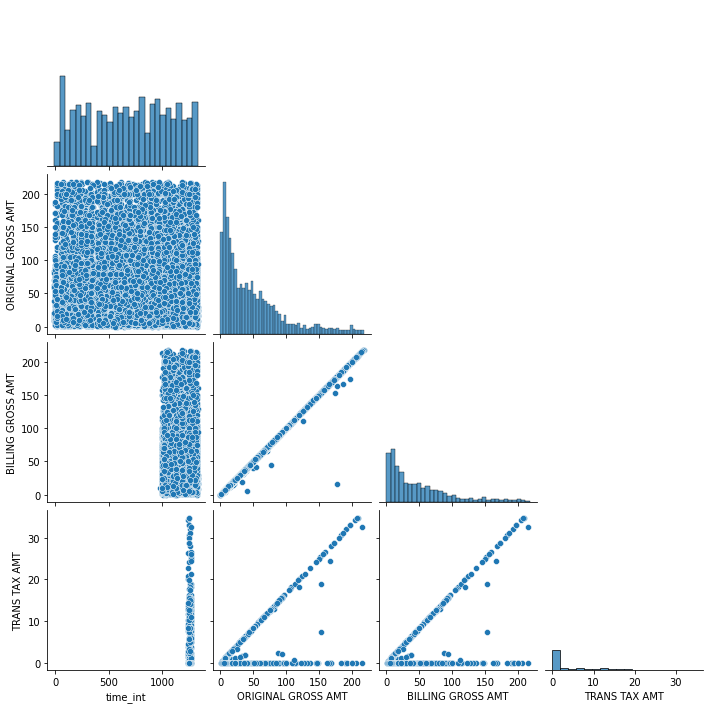

In [ ]:
df_temp= df.iloc[:,[-1,2,4,-2]]
sns.pairplot(df_temp.sample(20000), diag_kind="hist",corner=True)

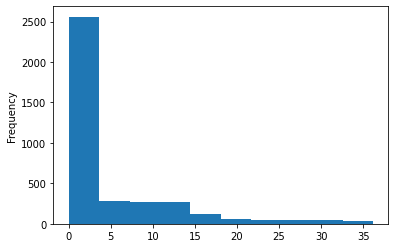

In [ ]:
column='TRANS TAX AMT'
df[column].plot(kind='hist')
#ax = sns.countplot(x=col, data=df_clean)

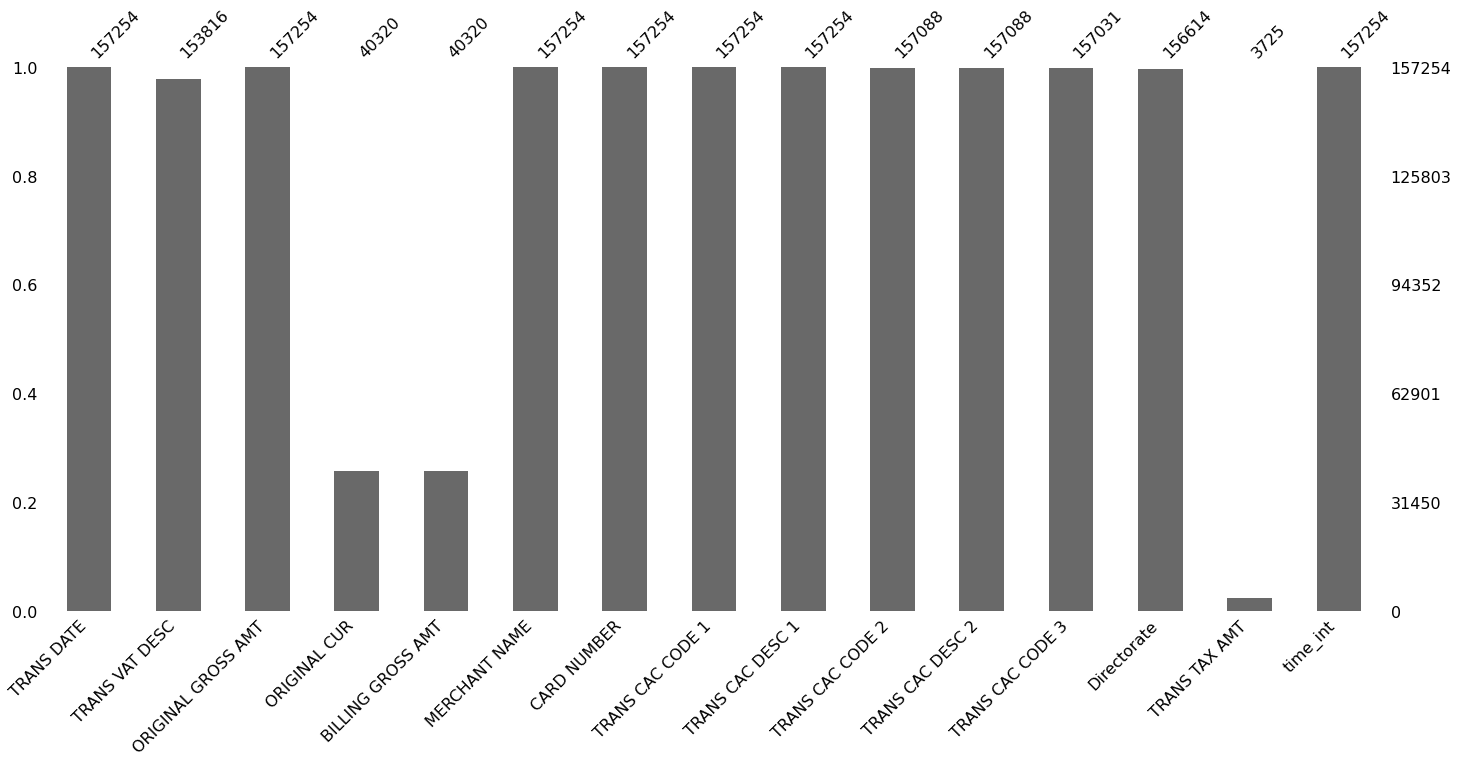

In [ ]:
pd.options.plotting.backend = "matplotlib"
msno.bar(df)

# Removal of missing data or redundant DATA
* Because the tax AMOUNT is only present on last part of the series (<year) and also the billing apears less than a third of time (circa 1.5 years) they will be dropped.


In [ ]:
df.drop(['TRANS TAX AMT','TRANS DATE','BILLING GROSS AMT'],axis=1, inplace=True)

* Also drop the high cardinality data left

In [ ]:
df.drop(['TRANS CAC CODE 2','TRANS CAC DESC 2'],axis=1, inplace=True)

# ANALYSIS per feature and other imputations

* Directorate


missing entries: 640, p%: 0.406984877968128


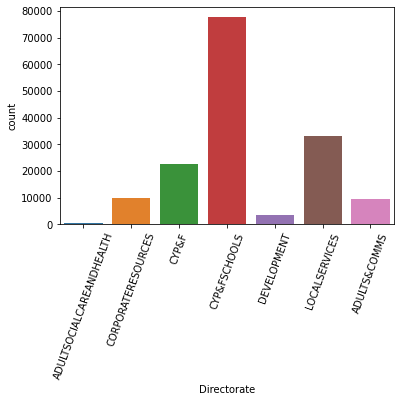

In [ ]:
col='Directorate'
missing = df[col].isna().sum()
print(f'missing entries: {missing}, p%: {missing/len(df)*100}')
ax = sns.countplot(x=col, data=df, )
plt.xticks(rotation=70)
df.dropna(axis=0, subset=[col], inplace=True)

missing entries: 213, p%: 0.1360031670221053


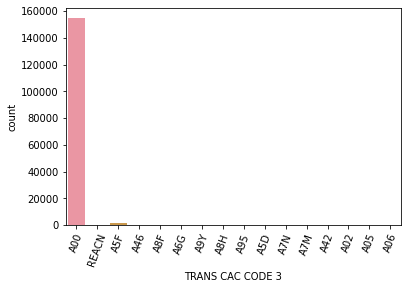

In [ ]:
col='TRANS CAC CODE 3'
missing = df[col].isna().sum()
print(f'missing entries: {missing}, p%: {missing/len(df)*100}')
ax = sns.countplot(x=col, data=df )
plt.xticks(rotation=70)
df.dropna(axis=0, subset=[col], inplace=True)

* lets replace it by  A00 or NON-A00.

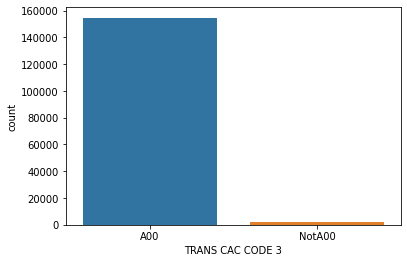

In [ ]:
nona00_list= df[col].unique()[1:]
df[col].replace(to_replace=nona00_list, value='NotA00' ,inplace=True)
ax = sns.countplot(x=col, data=df, )

In [ ]:
first_run= True
if first_run:
  df.to_pickle('data-intermediate-2.pkl')
  df.to_pickle(colab_path+'/data-intermediate-2.pkl')
else:
  df=pd.read_pickle(colab_path+'/data-intermediate-2.pkl')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156401 entries, 0 to 2688
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   TRANS VAT DESC      152972 non-null  object 
 1   ORIGINAL GROSS AMT  156401 non-null  float64
 2   ORIGINAL CUR        39600 non-null   object 
 3   MERCHANT NAME       156401 non-null  object 
 4   CARD NUMBER         156401 non-null  object 
 5   TRANS CAC CODE 1    156401 non-null  object 
 6   TRANS CAC DESC 1    156401 non-null  object 
 7   TRANS CAC CODE 3    156401 non-null  object 
 8   Directorate         156401 non-null  object 
 9   time_int            156401 non-null  float64
dtypes: float64(2), object(8)
memory usage: 18.1+ MB


* ORIGINAL CUR 
 - Determine if the variable has a time gap with swarmplot.
 - Determine if it can be reduced its categories.

missing entries: 116801, p%: 74.68046879495655


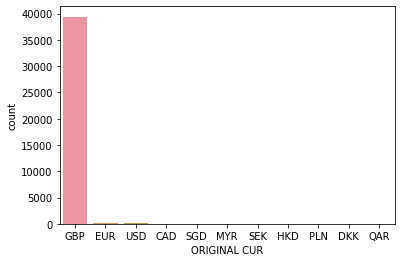

In [ ]:
col='ORIGINAL CUR'
missing = df[col].isna().sum()
print(f'missing entries: {missing}, p%: {missing/len(df)*100}')
ax = sns.countplot(x=col, data=df )
#plt.xticks(rotation=70)
#df.dropna(axis=0, subset=[col], inplace=True)

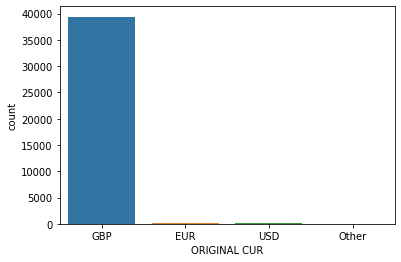

In [ ]:
other_cur_list= df[col].unique()[3:-1] #last is NaN currency.
#other_cur_list
df[col].replace(to_replace=other_cur_list, value='Other' ,inplace=True)
ax = sns.countplot(x=col, data=df, )

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning:

90.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



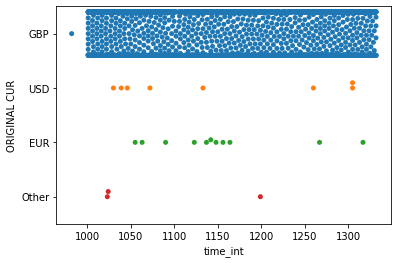

In [ ]:
ax = sns.swarmplot(x='time_int', y=col, data=df.sample(20000))

* It is evident that currency info was only included on the last year, and that the amount of those transactions other that GBP is very rare

* CARD NUMBER
 - Use swarmplots to find gaps and identify usage patterns 

In [ ]:
col= 'CARD NUMBER'
df[col]=df[col].apply(lambda x: int(x.replace('*','')))
df[col].nunique()

1419

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning:

9.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



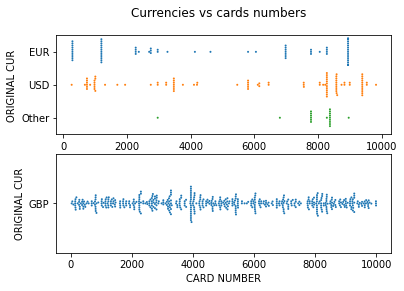

In [ ]:
ms=2
fig, axes = plt.subplots(2, 1)
fig.suptitle('Currencies vs cards numbers')

filter= df['ORIGINAL CUR']!='GBP'
df_temp=df[filter]
ax = sns.swarmplot(ax=axes[0], x='CARD NUMBER', y='ORIGINAL CUR', data=df_temp[0:500], size=ms)
plt.xlabel('')

filter= (df['ORIGINAL CUR']=='GBP')
df_temp=df[filter]
ax = sns.swarmplot(ax=axes[1], x='CARD NUMBER', y='ORIGINAL CUR', data=df_temp.sample(500), size=ms)


* It its now clear that  only few cards operate in currencies other than  GBP , especially aside of  non US and EUR .
* Also somo cards seems to be much more active(in GBP), this sugest to inspect time-usage scope, since CCards also expire, but no horizontal gaps were observed (see below)

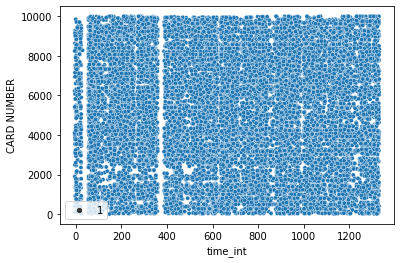

In [ ]:
ms=1
ax = sns.scatterplot(x='time_int', y='CARD NUMBER', data=df.sample(20000), size=ms)

In [ ]:
df['TRANS CAC CODE 1'].unique()

array(['K', 'M', 'L', 'X', 'H', 'J', 'P', 'rg10', 'N', '5C55'],
      dtype=object)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning:

16.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning:

46.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning:

7.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning:

22.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning:

12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py

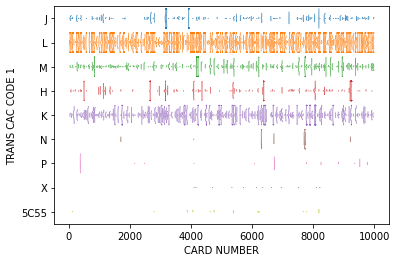

In [ ]:
ms=1.0
ax = sns.swarmplot( x='CARD NUMBER', y='TRANS CAC CODE 1', data=df.sample(10000), size=ms)

* there is no preference for cards to have an specific expenditure

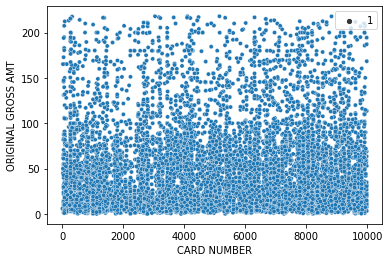

In [ ]:
ms=1
ax = sns.scatterplot(y='ORIGINAL GROSS AMT', x='CARD NUMBER', data=df.sample(10000), size=ms)

* Expenditure amount is widespread over the all range for all types of CODE 1, but is skewed to the low amounts and some appear to be bimodal.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning:

49.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning:

12.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



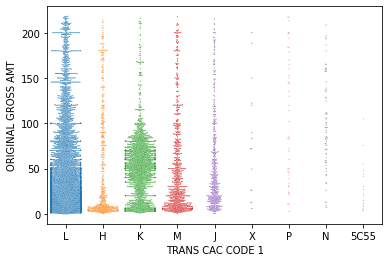

In [ ]:
ms=1
ax = sns.swarmplot(y='ORIGINAL GROSS AMT', x='TRANS CAC CODE 1', data=df.sample(10000), size=ms)

*VAT  feature is the last one with a small percentage of values. We prefer to drop them instead of changing the balance of the categories

missing entries: 3429, p%: 2.1924412248003526


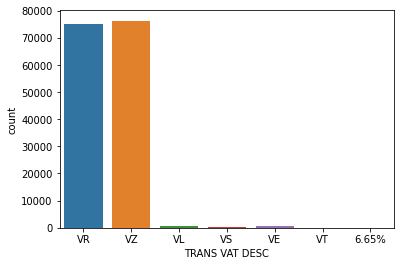

In [ ]:
col='TRANS VAT DESC'
missing = df[col].isna().sum()
print(f'missing entries: {missing}, p%: {missing/len(df)*100}')
ax = sns.countplot(x=col, data=df )
#plt.xticks(rotation=70)
df.dropna(axis=0, subset=[col], inplace=True)


* Also for the lack of history will drop the ORIGINAL CUR  feature although it has shown interesting patterns and CARD_NUMBER because is not ordinal and has a high cardinality
*  The largest Cardinality being MERCHANT NAME needs to drop since the Names are not fully related to the provider economical activity and abbreviated, it is difficult to find a define path to collapse them into large levels with guarantee of the effort required for approaches like semantic simililarity. Take for instance 'kfc billingham' and ' mbursts service' which for a human are food and a provides of a kind of service. 
* Finally the latter approach might probably succeed with the  TRANS CAC DESC 2, that includes 1.3K different short descriptions. It is not clear how to deal specific providers  abbreviations.

In [ ]:
df.drop(['ORIGINAL CUR', 'CARD NUMBER'],axis=1, inplace=True)

In [6]:
df.drop(['MERCHANT NAME'],axis=1, inplace=True)

In [ ]:
#at high percentage rate we can not Imputate but keep unknonw  
# Also it should convert to categorical
#df_clean[col].fillna(5, inplace=True)
#df_clean[col] = df_clean[col].astype('category',copy=False)

# finally report and saving

* Non null values, 1 timestamp feature, & 6 features (1 numerical and 5 Categorical)

In [8]:
df.info()
df.reset_index(inplace=True, drop=True)
df.to_pickle("bcouncil_clean.pkl")
df.to_pickle(colab_path+"/bcouncil_clean.pkl")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152972 entries, 0 to 152971
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   TRANS VAT DESC      152972 non-null  object 
 1   ORIGINAL GROSS AMT  152972 non-null  float64
 2   TRANS CAC CODE 1    152972 non-null  object 
 3   TRANS CAC DESC 1    152972 non-null  object 
 4   TRANS CAC CODE 3    152972 non-null  object 
 5   Directorate         152972 non-null  object 
 6   time_int            152972 non-null  float64
dtypes: float64(2), object(5)
memory usage: 8.2+ MB


In [5]:
first_run= False
df=pd.read_pickle(colab_path+'/bcouncil_clean.pkl')